In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


In [2]:
import tensorflow as tf

# Enable GPU memory growth if GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("✅ GPU memory growth enabled.")
    except:
        print("⚠️ Could not set GPU memory growth.")
else:
    print("🖥️ Running on CPU.")


✅ GPU memory growth enabled.


In [ ]:
# ⚠️ Skipped file movement to prevent large disk ops.
# # # Set absolute path to be safe
# # base_dir = 'data/dogs-vs-cats/train'
# # os.chdir(base_dir)
# 
# # print("📂 Current directory:", os.getcwd())
# 
# # # Use correct glob patterns
# # cat_images = glob.glob('cat.*.jpg')
# # dog_images = glob.glob('dog.*.jpg')
# 
# # # Debug: print first few files
# # print(f"🐱 Found {len(cat_images)} cat images")
# # print(f"🐶 Found {len(dog_images)} dog images")
# # print("🧪 Sample cat files:", cat_images[:3])
# # print("🧪 Sample dog files:", dog_images[:3])
# 
# # # Proceed only if not already organized
# # if not os.path.exists('train/dog'):
# #     # Create folders
# #     for split in ['train', 'valid', 'test']:
# #         os.makedirs(f'{split}/cat', exist_ok=True)
# #         os.makedirs(f'{split}/dog', exist_ok=True)
# 
# #     # Shuffle to randomize
# #     random.shuffle(cat_images)
# #     random.shuffle(dog_images)
# 
# #     # Split into train/valid/test
# #     train_cats = cat_images[:500]
# #     valid_cats = cat_images[500:600]
# #     test_cats = cat_images[600:650]
# 
# #     train_dogs = dog_images[:500]
# #     valid_dogs = dog_images[500:600]
# #     test_dogs = dog_images[600:650]
# 
# #     # Move cats
# #     for f in train_cats:
# #         shutil.move(f, 'train/cat')
# #     for f in valid_cats:
# #         shutil.move(f, 'valid/cat')
# #     for f in test_cats:
# #         shutil.move(f, 'test/cat')
# 
# #     # Move dogs
# #     for f in train_dogs:
# #         shutil.move(f, 'train/dog')
# #     for f in valid_dogs:
# #         shutil.move(f, 'valid/dog')
# #     for f in test_dogs:
# #         shutil.move(f, 'test/dog')
# 
# #     print("✅ Files moved successfully.")
# 
# # else:
# #     print("⚠️ Data already split. Delete folders if you want to re-run.")
# 

In [4]:
train_path = 'data/dogs-vs-cats/train'
valid_path = 'data/dogs-vs-cats/valid'
test_path = 'data/dogs-vs-cats/test'

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
                .flow_from_directory(directory=train_path, target_size=(224, 224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
                .flow_from_directory(directory=valid_path, target_size=(224, 224), classes=['cat', 'dog'], batch_size=10) 
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
                .flow_from_directory(directory=test_path, target_size=(224, 224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [6]:
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2 

In [7]:
imgs, labels = next(train_batches) # single batbh of 10 img size = 10

In [8]:
# This function plot images in the form of a grid with 1 row and 10 columns where images are placed

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..131.32].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-121.68..147.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..137.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-111.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-117.68..151.061].
Clipping input data t

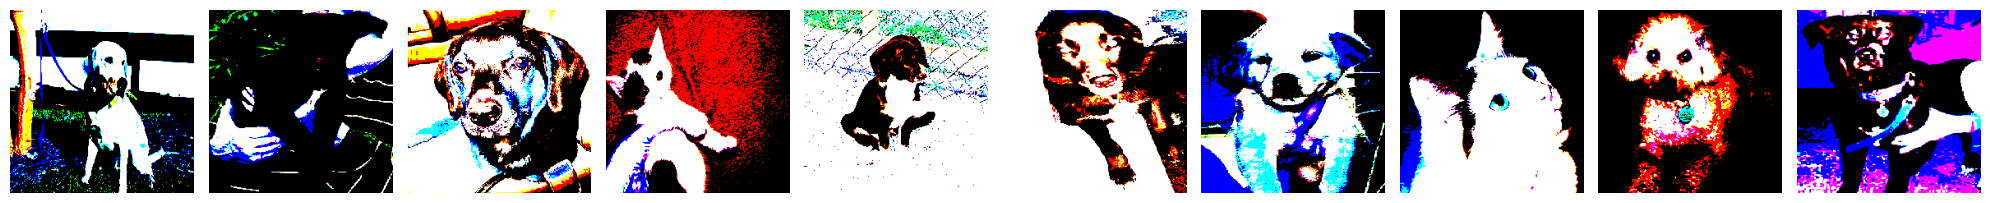

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [9]:
plotImages(imgs)
print(labels)

## Build and Train a CNN 

In [10]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224, 224, 3)), # 3 -> RGB
    MaxPool2D(pool_size=(2,2), strides=2), # MaxPool2D -> img dimention to 1/2
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'), 
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax'),
])

In [11]:
# from tensorflow.keras import backend as K
# K.clear_session()

In [12]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
# Debug: Check one batch from train_batches
images, labels = next(train_batches)
print('Train batch shape:', images.shape, labels.shape)

Train batch shape: (10, 224, 224, 3) (10, 2)


In [14]:
# Debug: Fit the model with reduced epochs and progress callback
from tensorflow.keras.callbacks import ProgbarLogger
model.fit(
    x=train_batches,
    validation_data=valid_batches,
    epochs=1,
    verbose=2,
    callbacks=[ProgbarLogger(count_mode='steps')]
)

100/100 - 5s - loss: 14.4670 - accuracy: 0.5780 - val_loss: 5.8522 - val_accuracy: 0.5550 - 5s/epoch - 46ms/step


In [15]:
model.fit(x = train_batches, validation_data= valid_batches, epochs=10, verbose=2)

Epoch 1/10
100/100 - 2s - loss: 2.4648 - accuracy: 0.7610 - val_loss: 3.1574 - val_accuracy: 0.6600 - 2s/epoch - 17ms/step
Epoch 2/10
100/100 - 2s - loss: 1.0670 - accuracy: 0.8630 - val_loss: 3.2821 - val_accuracy: 0.6250 - 2s/epoch - 17ms/step
Epoch 3/10
100/100 - 2s - loss: 0.1627 - accuracy: 0.9580 - val_loss: 2.9584 - val_accuracy: 0.6200 - 2s/epoch - 16ms/step
Epoch 4/10
100/100 - 2s - loss: 0.0592 - accuracy: 0.9830 - val_loss: 2.6373 - val_accuracy: 0.6200 - 2s/epoch - 16ms/step
Epoch 5/10
100/100 - 2s - loss: 0.0563 - accuracy: 0.9830 - val_loss: 2.3115 - val_accuracy: 0.7050 - 2s/epoch - 17ms/step
Epoch 6/10
100/100 - 2s - loss: 0.0214 - accuracy: 0.9920 - val_loss: 2.4922 - val_accuracy: 0.6300 - 2s/epoch - 16ms/step
Epoch 7/10
100/100 - 2s - loss: 0.0033 - accuracy: 0.9990 - val_loss: 2.3149 - val_accuracy: 0.6700 - 2s/epoch - 17ms/step
Epoch 8/10
100/100 - 2s - loss: 9.9809e-04 - accuracy: 1.0000 - val_loss: 2.2437 - val_accuracy: 0.6650 - 2s/epoch - 17ms/step
Epoch 9/10
1

## Predicton

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..86.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-122.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-116.779..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-111.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data 

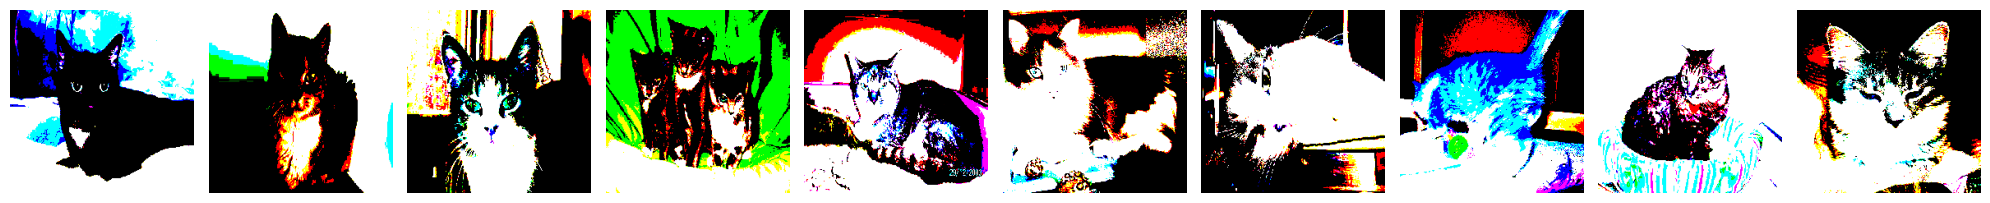

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [16]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [17]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [18]:
predictions = model.predict(x=test_batches, verbose=0)

In [19]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.

In [20]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [21]:
# From SKlearns website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    # Add text labels inside the boxes
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [22]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[32 18]
 [18 32]]


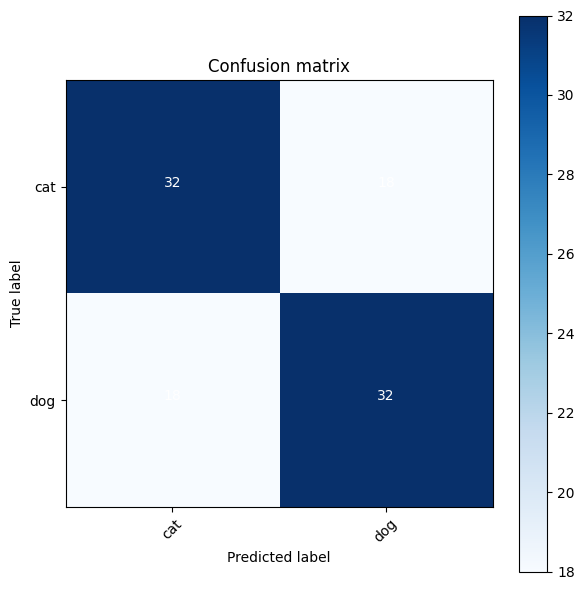

In [23]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion matrix')

# Build fine-tuned VGG16 model

In [24]:
# Download model - Internet Connection needed
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [25]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [26]:
type(vgg16_model)

keras.engine.functional.Functional

In [27]:
model = Sequential()
for layer in vgg16_model.layers[:-1]: # exclusding the last layer
    model.add(layer)

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [29]:
for layer in model.layers:
    layer.trainable = False

In [30]:
model.add(Dense(units=2, activation='softmax'))

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

# Train the Fine Tuned VGG16 model

In [32]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [33]:
model.fit(x = train_batches, validation_data= valid_batches, epochs=5, verbose=2)

Epoch 1/5
100/100 - 30s - loss: 0.2044 - accuracy: 0.9130 - val_loss: 0.1188 - val_accuracy: 0.9550 - 30s/epoch - 296ms/step
Epoch 2/5
100/100 - 5s - loss: 0.0734 - accuracy: 0.9760 - val_loss: 0.1058 - val_accuracy: 0.9600 - 5s/epoch - 46ms/step
Epoch 3/5
100/100 - 5s - loss: 0.0525 - accuracy: 0.9830 - val_loss: 0.0827 - val_accuracy: 0.9700 - 5s/epoch - 46ms/step
Epoch 4/5
100/100 - 5s - loss: 0.0385 - accuracy: 0.9890 - val_loss: 0.0760 - val_accuracy: 0.9700 - 5s/epoch - 47ms/step
Epoch 5/5
100/100 - 5s - loss: 0.0321 - accuracy: 0.9910 - val_loss: 0.0829 - val_accuracy: 0.9650 - 5s/epoch - 47ms/step


In [36]:
assert model.history.history.get('accuracy')[-1] > 0.95

# Predict using fine-tuned VGG16 model

In [37]:
predictions = model.predict(x= test_batches, verbose=0)

In [38]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [39]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [40]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[49  1]
 [ 0 50]]


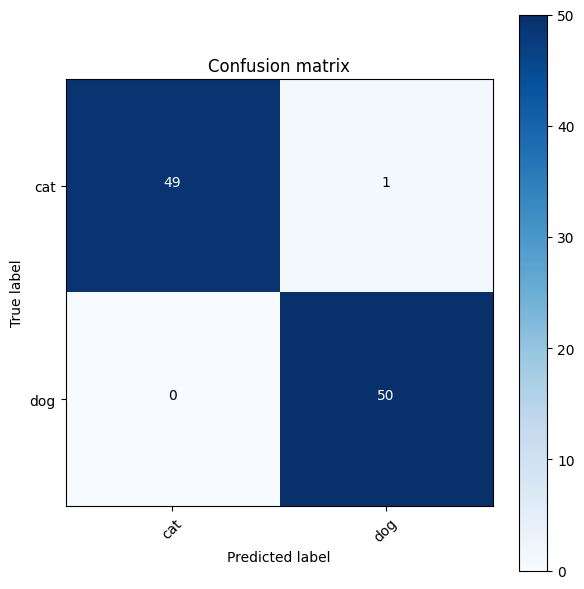

In [41]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion matrix')